In [1]:
#LIbraries
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
import xgboost as xgb
from pandarallel import pandarallel
import geopy.distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data preparation and exploration
In this section we load the datasets and explore our variables

In [2]:
events_df = pd.read_csv('events_1_1.csv.gz', compression='gzip')
iata_df = pd.read_csv('iata_1_1.csv')

print ("Events table is {0}".format(events_df.shape))

Events table is (47007, 9)


In [3]:
events_df.head(100)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0
5,2017-04-29 23:44:46,book,0dac26,2017-05-02,2017-05-02,BER,SCL,1,0
6,2017-04-29 23:12:34,search,7690da,2018-01-24,2018-01-26,SXF,VIE,2,0
7,2017-04-29 18:13:24,search,a4b138,2017-06-14,2017-06-14,HAM,ARN,2,0
8,2017-04-29 21:31:31,search,6df4fb,2017-10-12,2017-10-23,DUS,PMI,2,0
9,2017-04-29 18:56:35,search,eec403,2017-05-03,2017-05-06,HAM,LGW,1,0


In [4]:
iata_df.head(100)

,iata_code,lat,lon
0,LON,51.50,-0.17
1,MOW,55.75,37.70
2,NYC,40.71,-74.01
3,PAR,48.85,2.35
4,IST,41.01,28.95
5,DXB,25.07,55.17
6,CHI,41.85,-87.65
7,TYO,35.69,139.69
8,DXB,25.25,55.36
9,ATL,33.75,-84.39


Eyeballing the coordinates file, it looks like some iata_codes are kind of duplicated. For instance, if we look at the code ATL (Atlanta), we can see two entries: (33.75,-84.39) and (33.64, -84.42). Looking in a map, the distance between these two coordinates is just few kilometers. Same thing happens with many other entries.  

Since it's just few kilometers difference, I will keep just one of the entries for each place (the first).  

In [5]:
print ("Original iata_df table is {0}".format(iata_df.shape))
iata_df = iata_df.drop_duplicates(subset=['iata_code'], keep='first')
print ("After dropping dplicates iata_df table is {0}".format(iata_df.shape))


Original iata_df table is (500, 3)
After dropping dplicates iata_df table is (298, 3)


### Calculate distance between origin and destination

In [6]:
# Define functions
def calculate_distance(row):
    """This function calculates the distance in Km between two points, give the geocoordinates"""
    return geopy.distance.distance((row['lat_origin'], row['lon_origin']), 
                                   (row['lat_destination'], row['lon_destination'])).km


In [7]:
# Concatenate the events and coordinates tables both for the origin and destination

# Origin
events_df = events_df.merge(iata_df, how='left', left_on='origin', right_on='iata_code')
events_df = events_df.rename(columns = {'lat':'lat_origin', 'lon':'lon_origin', }) 

# Destination
events_df = events_df.merge(iata_df, how='left', left_on='destination', right_on='iata_code')
events_df = events_df.rename(columns = {'lat':'lat_destination', 'lon':'lon_destination', }) 

events_df = events_df.drop(['iata_code_x', 'iata_code_y'],  axis=1)

# Let's just print the size of the events table, to make sure we haven't introduced any unwanted artifact by mistake.
# Since we performed a left join, it should have exactly the same size as at the original events file.
print ("Events table is {0}".format(events_df.shape))


Events table is (47007, 13)


In [8]:
# Get all the unique combinations of origin and destination, 
# in order to avoid making the same calculation several times and speed the processing time
origin_destination = events_df[['origin', 'destination', 
                                'lat_origin', 'lon_origin', 
                                'lat_destination', 'lon_destination']].drop_duplicates()
print ("We have speed it up by {0}%".format(str( ( 1- (len(origin_destination)/ len(events_df))) * 100 )))

We have speed it up by 90.06956410747335%


In [9]:
# In order to speed the processing up, we can run it in parallel using the apply function from Pandarallel.
# For this particular ejercise we don't have that much data and paralelizing the processing doesn't probably make
# that much sense, but in a real world scenario we probably have much more data. 
pandarallel.initialize(progress_bar=True)

origin_destination['distance']= origin_destination[['lat_origin', 
                                                      'lon_origin', 
                                                      'lat_destination', 
                                                      'lon_destination']].parallel_apply(calculate_distance, axis=1)




INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [10]:
# And now that we have the distance, we need to merge it again on the events table
events_df = events_df.merge(origin_destination[['origin', 'destination', 'distance']], how='left', left_on=['origin', 'destination'], right_on=['origin', 'destination'])

print ("Events table is {0}".format(events_df.shape))



Events table is (47007, 14)


In [11]:
events_df.head(5)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,lat_origin,lon_origin,lat_destination,lon_destination,distance
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,48.85,2.35,40.71,-74.01,5853.514776
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1,50.12,8.68,38.90,-77.04,6547.118447
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0,52.52,13.41,50.88,7.12,471.393292
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0,52.52,13.41,41.39,2.16,1500.918498
4,2017-04-27 22:51:57,book,ca4f94,2017-05-16,2017-05-22,DEL,BKK,4,0,28.57,77.10,13.75,100.50,2922.370862


### Explore the dataset
Now that we already have calculated the distance, let's explore the dataset a bit to see with what are we dealing with 

In [12]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47007 entries, 0 to 47006
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ts               47007 non-null  object 
 1   event_type       47007 non-null  object 
 2   user_id          47007 non-null  object 
 3   date_from        46985 non-null  object 
 4   date_to          47004 non-null  object 
 5   origin           47007 non-null  object 
 6   destination      47007 non-null  object 
 7   num_adults       47007 non-null  int64  
 8   num_children     47007 non-null  int64  
 9   lat_origin       47007 non-null  float64
 10  lon_origin       47007 non-null  float64
 11  lat_destination  47007 non-null  float64
 12  lon_destination  47007 non-null  float64
 13  distance         47007 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 5.4+ MB


Here we can see:
- We have a number of continuous variables: distance, num_children, num_adults
- We also have categorical variables: origin, destination
- We have other variables that we can use to do some feature engineering, such as dates (date_from, date_to, ts) and user_id
- There are almost no missing values, just few for date_from variable

Now let's have a look at the variables

#####  How many levels do our categorical variables have?

In [13]:
# Let's display the value counts for the two categorical variables
categorical_var = ['origin', 'destination']
events_df[categorical_var].apply(pd.Series.value_counts)


,origin,destination
ABV,4.0,8.0
ADB,21.0,124.0
ADD,NaN,39.0
ADL,4.0,15.0
AER,2.0,21.0
AGP,80.0,682.0
AKL,18.0,114.0
ALA,4.0,51.0
ALC,55.0,381.0
ALG,32.0,818.0


It looks like these variables would generate a decent number of dummy variables

##### How do continuous variables look like? Do we have outliers?

There are several things we can do to detect outliers.

- Visually, we can just plot the data with a boxplot (which uses IQR scores)

- We can calculate the Z-scores, and see is there are data points too far from the mean (for instance, with a higher z-score than 3, that is, 3 standard deviations from the mean).


For this exercise we will just use plot boxplots

In [14]:
events_df.describe()

,num_adults,num_children,lat_origin,lon_origin,lat_destination,lon_destination,distance
count,47007.000000,47007.000000,47007.000000,47007.000000,47007.000000,47007.000000,47007.000000
mean,1.676261,0.146723,47.948604,8.336898,37.793593,9.938958,3229.082613
std,0.988610,0.477620,8.555416,21.022635,17.633702,51.817638,3548.048872
min,0.000000,0.000000,-43.530000,-157.930000,-43.530000,-157.930000,9.279100
25%,1.000000,0.000000,48.140000,4.350000,36.720000,-3.370000,835.548504
50%,1.000000,0.000000,48.850000,8.680000,41.010000,7.220000,1560.354551
75%,2.000000,0.000000,51.220000,10.020000,48.850000,27.140000,5245.303939
max,9.000000,5.000000,64.130000,177.420000,64.840000,177.420000,19436.883648


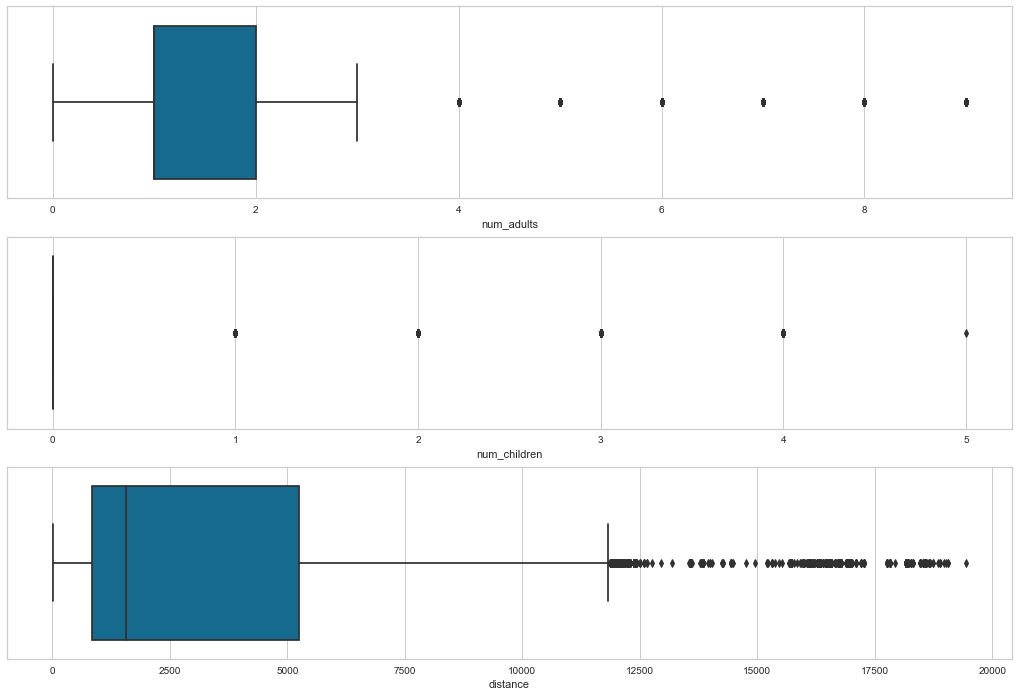

In [15]:
f, axes = plt.subplots(nrows=3, figsize=(18, 12))

sns.boxplot(x=events_df['num_adults'],ax=axes[0])
sns.boxplot(x=events_df['num_children'], ax=axes[1])
sns.boxplot(x=events_df['distance'], ax=axes[2])


#####  What do we do with the outliers?

From the previous graphs we can see there are some outliers.
We can do several things:

- Keep them. Some algorithms are able to handle outliers. Sometimes the outliers can even be fundamental in building the regression.  

- Drop them. We need to be careful that we don't drop too much data (> 10%), specially if we don't have many rows. 

- Use a transformation such as log transformation. Logarithmic transformation is a way of transforming a highly skewed variable into a more normalized dataset. This will also  improve the fit of the model by transforming the distribution of the features to a more normally-shaped curve.

On top of it, we can see that the variables have different scales, so we might have to consider normalizing it.

#####  How do our time variables look like?

In [16]:
# First of all, let's convert them to datetime
events_df[['ts','date_from','date_to']] = events_df[['ts','date_from','date_to']].apply(pd.to_datetime)



Ts goes from 2017-04-18 04:41:09 to 2017-05-02 04:06:34


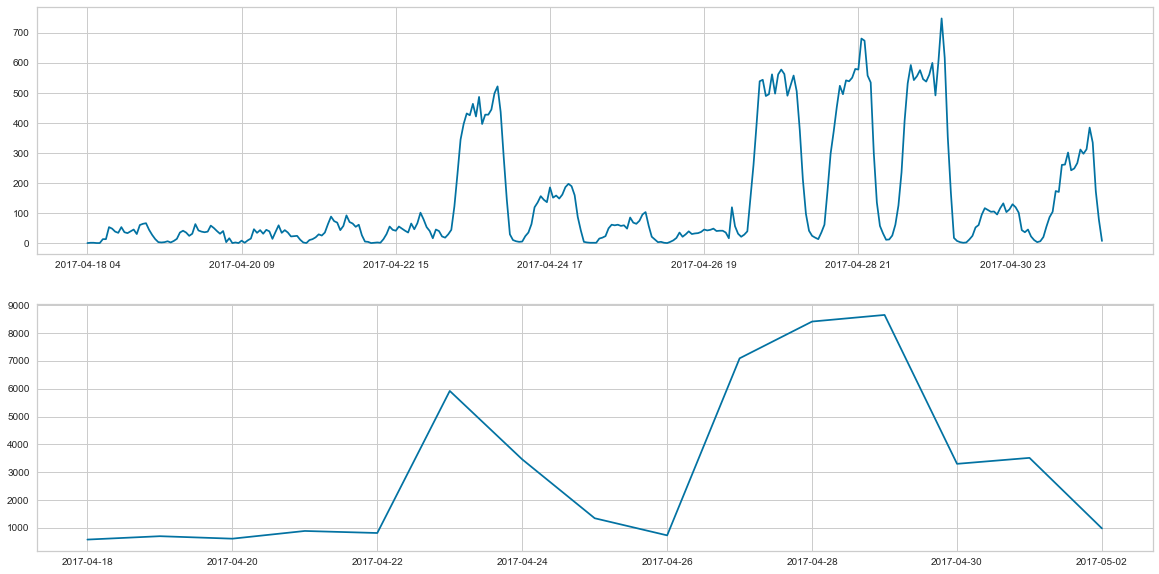

In [17]:
# TS:  Let's just plot a simple graph to get some idea of the frequencies per hour and per day
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

# Per hour
events_df['ts'].dt.strftime('%Y-%m-%d %H').value_counts(sort=False).sort_index().plot(ax= ax1)

# Per day
events_df['ts'].dt.strftime('%Y-%m-%d').value_counts(sort=False).sort_index().plot(ax= ax2)

print ("Ts goes from {0} to {1}".format(min(events_df['ts']), max(events_df['ts'])))

Interestingly, we can see some clear picks in the data, where the system got so many searches over a sort period of time.

Also, if we look at the day of the week, we can see some slight day of the week seasonality effect (22-23 and 29-30 are weekends). 

I would like to know to what extent these peaks where created by a bunch of unique users, just to understand the data we are dealing with.

In [18]:
print("Unique users: {0}%".format( str(len(events_df['user_id'].unique()) / len(events_df) * 100)))


Unique users: 66.32841917161274%


<ipython-input-19-80949abcde0f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_freq['ts'] = user_freq['ts'].dt.strftime('%Y-%m-%d %H')


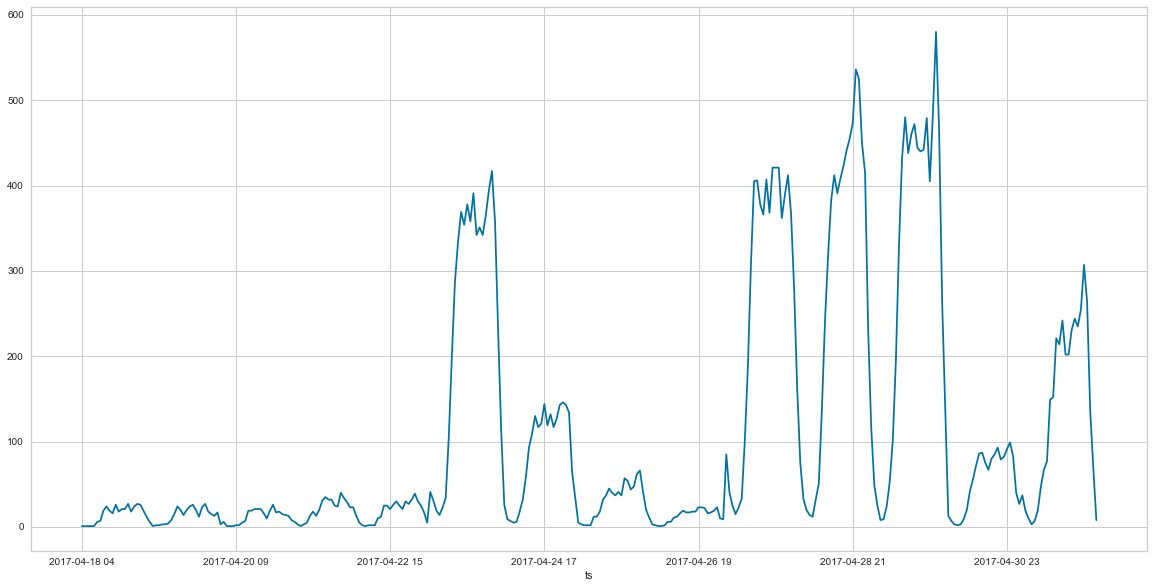

In [19]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))

# Here I want to get the number of unique users per hour. 
# If the graph looks similar to the previous graph, it means that it is multiple users creating the peak
user_freq = events_df[['user_id','ts']]
user_freq['ts'] = user_freq['ts'].dt.strftime('%Y-%m-%d %H')

# We need to do two groupbys: First, to get the user - ts combinations, and second, to count the unique users for each ts
user_freq.groupby(['user_id','ts']).count().reset_index().groupby(['ts'])['ts'].count().plot(ax = ax1)


It looks like multiple users were hitting the system at these peaks, so maybe it has to do with other effects like the campaign being active at these times. 

##### How does the target variable look like? is it balanced?

In [20]:
events_df['event_type'].value_counts()

search    45198
book       1809
Name: event_type, dtype: int64

As suspected, it looks pretty unbalanced, so we will have to deal with it later.

### Data transformation and feature engineering
This dataset gives so many options to compute new metrics. I will outline here the most obvious ones:

- is_returning_user (values =[0,1]). This variable determines whether the user is new in the system (0) or not (1)
- n_visits (values = int). This variable specifies the number of visits for a particular user. 
- has_conversions (values =[0,1]).  This variable determines whether the user has past conversions (0) or not (1)
- n_conversions (values = int). This variable specifies the number of conversions for a particular user.
- time_since_prev_visit (values = minutes, float). This variable specifies the time in min since the previous search. For first time users it would be NaN. 
- same_destination_last_24h (values = [0,1]). When we try to book a fly, we might know the destination but still perform several searches slighly changing the dates in order to book the date with the best price. This variable tells us whether we did a search in the last 24 hours with the same origin and destination, but changing other parameters such as dates. We could here play a bit with the parameters and see what performs best. For instance, we might want to seach just for the last hour.
- same_dates_last_24h (values = [0,1]). Similarly, we might not be so sure about the destination either and we decide to try different options. 
- days_between_from_to (values = days, int). The time between date_from to date_to. The holiday period might be related to the likelihood of booking a holiday.
- days_until_holiday (values = days, int). This variable indicates how many days ahead we are booking the holiday. When we are booking a holiday with a short notice, it might be more likely we go ahead and book it since we have less time to think about it and fewer available options.

We can get even more creative and think about some other features, but I have the feeling that the combination of those could already provide some interesting predictions for the model. For this exercise I have to just choose three, so I will compute:

- n_visits. This variable already contains the information from is_returning_user and it might add some interesting information to the model. 
- time_since_prev_visit. It is certainly not the same if we are actively searching, or if our last visit happened 6 months ago. 
- change_dates_last_24h. Intuitively,  would say the likelihood of conversion is higher when we already know where we want to go to, but are just trying to find the best dates.  

In [21]:
data_transf_df = events_df

# let's sort values just in case
data_transf_df = data_transf_df.sort_values(by=['ts'])

# Let's delete duplicates, a user cannot do two searchs in exactly the same second, so this must be an artifact.
data_transf_df = data_transf_df.drop_duplicates(subset=['user_id', 'ts'], keep='first')

print( "There were {0}% of duplicates ".format(str((len(events_df) - len(data_transf_df)) / len(events_df) * 100)))
print ("Events table is {0}".format(data_transf_df.shape))

There were 3.605845937839045% of duplicates 
Events table is (45312, 14)


There were surprinsingly duplicates in the data for user_id-ts combination. For this exercise I will just delete them and keep the first entry, but this should probably be investigated.

##### Target variable

In [22]:
# we transform it to 0/1
data_transf_df['target_variable'] = data_transf_df['event_type'].str.replace("search", "0").str.replace("book", "1").apply(int)


##### n_visits
We will specify a time window of 6 months

In [23]:
time_window = '180d'

n_visits = data_transf_df.reset_index().set_index('ts').groupby('user_id').rolling(time_window)['index'].count().reset_index()
n_visits = n_visits.rename(columns={'index': 'n_visits'})

# The rolling function counts also the current visit, so we need to substract 1 to all records
n_visits['n_visits'] = n_visits['n_visits'] - 1

In [24]:
n_visits.head(300)


,user_id,ts,n_visits
0,000069,2017-04-29 17:59:51,0.0
1,00019d,2017-04-28 19:14:23,0.0
2,0002e3,2017-04-24 21:25:10,0.0
3,000332,2017-04-27 16:34:02,0.0
4,000332,2017-04-27 16:35:35,1.0
5,000332,2017-04-27 16:39:10,2.0
6,000332,2017-04-27 21:24:01,3.0
7,0004e1,2017-04-29 01:06:18,0.0
8,0004e1,2017-04-29 01:06:41,1.0
9,0004f1,2017-04-29 23:42:19,0.0


Eyeballing the data, the results seem correct and make sense.

In [25]:
# Now we need to merge the n_visits with the events table based on user_id and ts, which need to be unique.
data_transf_df = data_transf_df.merge(n_visits, how='left', left_on=['user_id', 'ts'], right_on=['user_id', 'ts'])

# Double check:
print ("Events table is {0}".format(data_transf_df.shape))

Events table is (45312, 16)


In [26]:
data_transf_df.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,lat_origin,lon_origin,lat_destination,lon_destination,distance,target_variable,n_visits
0,2017-04-18 04:41:09,search,10fc25,2017-05-05,2017-05-18,MRS,MIA,1,0,43.44,5.21,25.77,-80.19,7734.565897,0,0.0
1,2017-04-18 06:08:06,search,2c3d94,2017-05-30,2017-06-02,FRA,BCN,2,0,50.12,8.68,41.39,2.16,1093.899594,0,0.0
2,2017-04-18 06:11:20,search,2c3d94,2017-05-30,2017-06-02,FRA,BCN,2,0,50.12,8.68,41.39,2.16,1093.899594,0,1.0
3,2017-04-18 07:18:38,search,a8590b,2017-04-19,2017-05-24,HAM,BCN,1,0,53.58,10.02,41.39,2.16,1476.929547,0,0.0
4,2017-04-18 07:40:59,search,a8590b,2017-04-19,2017-04-22,HAM,BCN,1,0,53.58,10.02,41.39,2.16,1476.929547,0,1.0


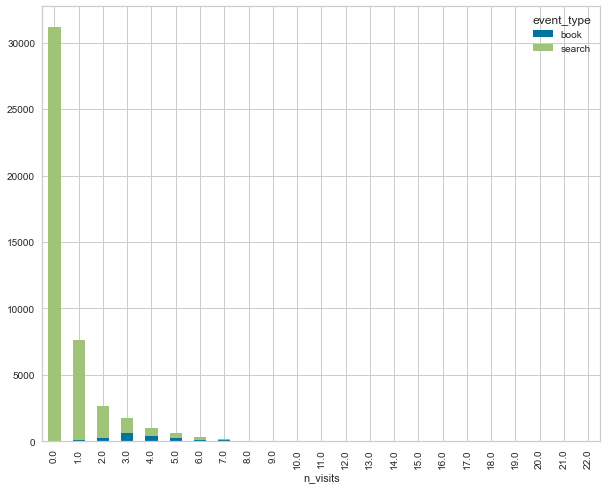

In [27]:
# Let's plot the data to see if there is any obvious relationship with the target variable. 
df = data_transf_df.groupby(['n_visits', 'event_type'])['ts'].count().unstack('event_type').fillna(0)
df.plot(kind="bar",stacked=True,figsize=(10,8))

This actually looks promissing. 

##### time_since_prev_visit

In [28]:
# Let's calculate the difference in minutes
data_transf_df['time_since_prev_visit'] = data_transf_df.groupby('user_id')['ts'].diff().apply(lambda x: x.total_seconds()) / 60


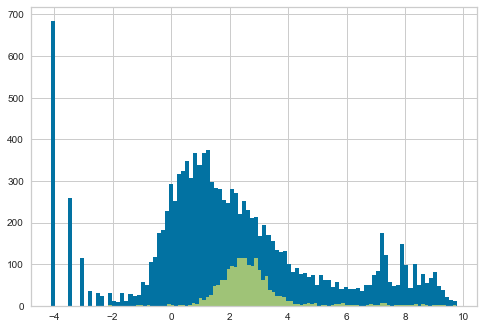

In [29]:
# Let's just plot it to get a clue if there is any relationship with the target variable
df_search = data_transf_df[data_transf_df['event_type'] == 'search']
df_book = data_transf_df[data_transf_df['event_type'] == 'book']

# I will plot it with a log transformation, otherwise it's hard to see anything
np.log(df_search['time_since_prev_visit']).hist(bins=100)
np.log(df_book['time_since_prev_visit']).hist(bins=100)


##### same_destination_last_24h

In [30]:
time_window = '24h'

n_same_destination = data_transf_df.reset_index().set_index('ts').groupby(['user_id', 'origin','destination']).rolling(time_window)['index'].count().reset_index()

n_same_destination = n_same_destination.rename(columns={'index': 'same_destination_last_24h'})

# In this case we just want 0 or 1
n_same_destination['same_destination_last_24h'] = n_same_destination['same_destination_last_24h'] - 1
n_same_destination.loc[n_same_destination['same_destination_last_24h'] > 0,'same_destination_last_24h'] = 1

In [31]:
# Now we need to merge the n_visits with the events table based on user_id and ts, which need to be unique.
data_transf_df = data_transf_df.merge(n_same_destination[['user_id', 'ts', 'same_destination_last_24h']], how='left', left_on=['user_id', 'ts'], right_on=['user_id', 'ts'])

# Double check:
print ("Events table is {0}".format(data_transf_df.shape))

Events table is (45312, 18)


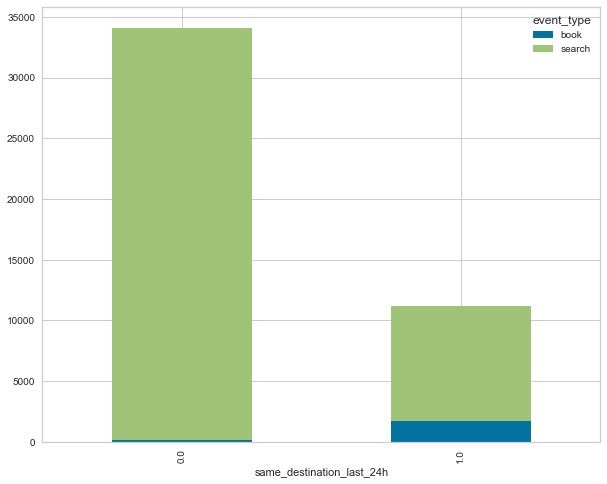

In [32]:
# Let's plot it
df = data_transf_df.groupby(['same_destination_last_24h', 'event_type'])['ts'].count().unstack('event_type').fillna(0)
df.plot(kind="bar",stacked=True,figsize=(10,8))

The graph also looks good.

### Convert the data to the right format
- For categorical variables, in case they have more than 2 levels (0,1) we need to dummify them
- For continuous variables, we might want to normalize (which needs to be done after the train/test split, to avoid data leakage).

In [33]:
continuous_variables = ['distance', 'time_since_prev_visit', 'num_adults', 'num_children', 'n_visits']
categorical_variables = ['origin', 'destination']

dummies = pd.get_dummies(data_transf_df[categorical_variables])
data_transf_df= pd.concat([data_transf_df, dummies], axis=1)

# Let's store the cotegorical predictors for later:
categorical_variables = list(dummies.columns) + ['same_destination_last_24h']

# Modelling 

### Train / test time based split
Since since data has a strong time component, it is more appropiate to split the data based on time. That is, we would use the first 80% of the data for training, and the last 20% for testing.

In [34]:
predictors = categorical_variables + continuous_variables
target = 'target_variable'

In [35]:
# The data is already sorted by date, so we just need to use the shuffle=False option from train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_transf_df[predictors],data_transf_df[target], test_size=0.2, shuffle=False)


### Normalize continuous variables
In the previous analysis we have seen that the continuous variables have different scales. Depending on what algorithm we use, normalizing is actually not needed (eg. for tree based model). Nevertheless, we can make it easier for the algorithm by normalizing it. 

It as also important to normalize after doing the train-test split to avoid data leakage, so that the model doesn't use information not available at prediction time.

For normalization I will use a MinMaxScaler.

We have different options for normalizing:
- <b> Normalize continues variables and ignore outliers. </b> Just applying MinMaxScaler

- <b> First remove outliers and normalize afterwards. </b> Also with MinMaxScaler

- <b> Use log transformation to normalize the curve and incorporate outliers. </b> 

For this exercise I will just normalize, but we could potentially improve performance by playing with these options.

I won't normalize all the continuous variables,  I will leave the ones with counters, since they don't go too high up anyway. 

In [36]:
continuous_variables_norm = ['distance', 'time_since_prev_visit']

# We need a different scaler for each variable, because we will need to use it␣,→later to scale the variables in the test file
# We will store the scaler in a dictionary
scalers_dic={}
for sub in continuous_variables_norm:
    pt=MinMaxScaler()
    scalers_dic.update({sub: pt })
    X_train[sub]=pt.fit_transform(X_train[[sub]])


In [37]:
# Here we have the objects that we would use at the end when predicting new events
scalers_dic

{'distance': MinMaxScaler(), 'time_since_prev_visit': MinMaxScaler()}

### Choose the right model

Since we need to predict a category, this is a classification problem. 
We have a number of Classifi-cation algorithms we can use, and we will choose the one that is most appropiate for us based onthe data we have: 
- Logistic regression This is the most simple form of Classification, which builds a linear (or non-linear) model to define a decision boundary. Generally, this is not the right choice if we have categorical predictors. 
- Decision Trees. This is the most basic tree algorithm, which builds a tree where nodes are split into branches based on the values of one or several predictors.Each branch of the decision tree represents a possible decision, outcome, or reaction. These kind of models are easy to interpret (one can even print the resulting tree after the trainning phase),but tend to overfit quite easily. 
- Random forest. These algorithms use what is called the bagging method. It builds several decision trees, and merge them together at the end in order to get more accurate and stable predictions. This intends to avoid overfitting. 
- XGboost. This is a gradient boosted decision tree. As random forest, it creates several trees, but these are added sequentially and each tries to correct the errors made by previous models. New models are added until no fur-ther improvents are made. Gradien boosting algorithms use gradient descent algorithm to minimizethe lost when adding new models

For this excercise I will use the Xgboost model because: 

- We have a decent number of categoricalvariables, then a tree based model makes sense 
- it is easy to control overfitting, for instance setting the early_stopping_rounds (so the model stops“improving” after the errors didn’t improve in X number of rounds ) 
- It’s fast due to the parallel processing 
- Includes regularization to avoid overfitting (with alpha and lambda metaparameters)
- We can tune scale_post_weight hyperparameter to deal with class imbalance,   which tends to work better than over and dowmsampling

### scale_post_weight  to deal with class imbalance
XgBoost provides a hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problems.
scale_pos_weight aims to weight the balance of positive examples, relative to negative examples when boosting decision trees. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1).
Thus, a way to calculate this value is:

scale_pos_weight = total_negative_examples / total_positive_examples

In [38]:
scale_pos_weight = len(data_transf_df[data_transf_df[target]== 0]) / len(data_transf_df[data_transf_df[target]== 1])
print ("scale_pos_weight is {0}".format(scale_pos_weight))

scale_pos_weight is 24.061946902654867


### Parameter-tuning: Calculating best metaparameters
ML algorithms have a number of metaparameters that can be tuned.Generally, for each parameter we can choose a set of values that could potentially work well, and then these are evaluated using GridSearch.

This procedure can be done in your local machine, but if we want it to be fast SageMaker mightbe a better choice.In the interest of time for this exercise I won’t include the Grid Search step and I will use somedefault values for the metaparameters.

In [39]:
# Metaparameters for the xgboost model. These are some defaut parameters, but
#,should actually be tunned using GridSearch or in SageMaker

xgb_model=xgb.XGBClassifier (objective="binary:logistic",
                             eval_metric="logloss",# This is the evaluation metric
                             alpha=0.6681275942899043,
                             max_depth=15,
                             eta=0.02877577956369699,
                             nthread=8,# align with number of cores in production deployment
                             booster="gbtree",
                             subsample=0.7653369592804922,
                             min_child_weight=8.338830332352881,
                             colsample_bytree=0.6914311400265004,
                             colsample_bylevel=0.5250360651638204,
                             scale_pos_weight = scale_pos_weight)




For the evaluation metric, I will use the logloss . Log Loss quantifies the accuracy of a classifier bypenalising false classifications. Minimising the Log Loss is basically equivalent to maximising theaccuracy of the classifier.

In [40]:
# Here we fit the model with the trainning data.
# We have a look at the log loss for train and test sets for each iteration
xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.67097	validation_1-logloss:0.67113
[1]	validation_0-logloss:0.64960	validation_1-logloss:0.64989
[2]	validation_0-logloss:0.63133	validation_1-logloss:0.62927
[3]	validation_0-logloss:0.61216	validation_1-logloss:0.61374
[4]	validation_0-logloss:0.59412	validation_1-logloss:0.59472
[5]	validation_0-logloss:0.57627	validation_1-logloss:0.57729
[6]	validation_0-logloss:0.55954	validation_1-logloss:0.55995
[7]	validation_0-logloss:0.54543	validation_1-logloss:0.54414
[8]	validation_0-logloss:0.53057	validation_1-logloss:0.52799
[9]	validation_0-logloss:0.51675	validation_1-logloss:0.51238
[10]	validation_0-logloss:0.50308	validation_1-logloss:0.50072
[11]	validation_0-logloss:0.48960	validation_1-logloss:0.48694
[12]	validation_0-logloss:0.47886	validation_1-logloss:0.47411
[13]	validation_0-logloss:0.46690	validation_1-logloss:0.46081
[14]	validation_0-logloss:0.45560	validation_1-logloss:0.44778
[15]	validation_0-logloss:0.44418	validation_1-logloss:0.43631
[1

XGBClassifier(alpha=0.6681275942899043, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5250360651638204, colsample_bynode=1,
              colsample_bytree=0.6914311400265004, eta=0.02877577956369699,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0287757795,
              max_delta_step=0, max_depth=15,
              min_child_weight=8.338830332352881, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8, nthread=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0.668127596,
              reg_lambda=1, scale_pos_weight=24.061946902654867,
              subsample=0.7653369592804922, tree_method='exact',
              validate_parameters=1, verbosity=None)

One of the nice advantages of the xgboost classifier is that it has a built- in cross validation system and it runs a cross validation for each iteration. 
In the log we can see how the log loss goes down for each iteration. 
Also, the test log loss is slighly over the trainning log loss, which is a good sign.If it was much lower, that would mean that the model is overfitting

### Evaluate the model with the test set

In [41]:
# make predictions for test data and calculate accuracy
y_pred=xgb_model.predict(X_test)

# evaluate predictions
accuracy=accuracy_score(y_test, y_pred)

print("Accuracy:%.2f%%"%(accuracy*100.0))


Accuracy:95.28%


Logloss and accuracy look good!

### Feature importance
Let's have a look what features have more weight in the model

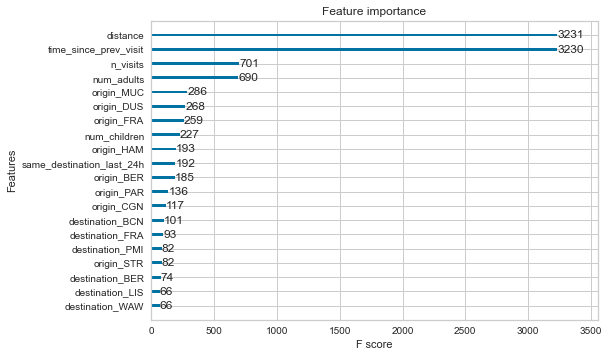

In [42]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20)

It looks like the features calculated are quite relevant for the model 